In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_openml

mnist = fetch_openml("MNIST_784")
mnist.data.shape
'''
MNIST data is in grey scale [0, 255].
Convert it to a binary scale using a threshold of 128.
'''
mnist3 = (mnist.data.to_numpy()/128).astype('int')

In [2]:
def bernoulli(data, means):
    '''To compute the probability of x for each bernouli distribution
    data = N X D matrix
    means = K X D matrix
    prob (result) = N X K matrix 
    '''
    N = len(data)
    K = len(means)
    #compute prob(x/mean)
    # prob[i, k] for ith data point, and kth cluster/mixture distribution
    prob = np.zeros((N, K))
    
    for i in range(N):
        for k in range(K):
            prob[i,k] = np.prod((means[k]**data[i])*((1-means[k])**(1-data[i])))
    
    return prob

def respBernoulli(data, weights, means):
    '''To compute responsibilities, or posterior probability p(z/x)
    data = N X D matrix
    weights = K dimensional vector
    means = K X D matrix
    prob or resp (result) = N X K matrix 
    '''
    #step 1
    # calculate the p(x/means)
    prob = bernoulli(data, means)
    
    #step 2
    # calculate the numerator of the resp.s
    prob = prob*weights
    
    #step 3
    # calcualte the denominator of the resp.s
    row_sums = prob.sum(axis=1)[:, np.newaxis]
    
    # step 4
    # calculate the resp.s
    try:
        prob = prob/row_sums
        return prob
    except ZeroDivisionError:
        print("Division by zero occured in reponsibility calculations!")

def bernoulliMStep(data, resp):
    '''Re-estimate the parameters using the current responsibilities
    data = N X D matrix
    resp = N X K matrix
    return revised weights (K vector) and means (K X D matrix)
    '''
    N = len(data)
    D = len(data[0])
    K = len(resp[0])
    
    Nk = np.sum(resp, axis=0)
    mus = np.empty((K,D))
    
    for k in range(K):
            mus[k] = np.sum(resp[:,k][:,np.newaxis]*data,axis=0) #sum is over N data points
            try:
                mus[k] = mus[k]/Nk[k]   
            except ZeroDivisionError:
                print("Division by zero occured in Mixture of Bernoulli Dist M-Step!")
                break           
    
    return (Nk/N, mus)

def llBernoulli(data, weights, means):
    '''To compute expectation of the loglikelihood of Mixture of Beroullie distributions
    Since computing E(LL) requires computing responsibilities, this function does a double-duty
    to return responsibilities too
    '''
    N = len(data)
    K = len(means)
    
    resp = respBernoulli(data, weights, means)
    
    ll = 0
    for i in range(N):
        sumK = 0
        for k in range(K):
            try:
                temp1 = ((means[k]**data[i])*((1-means[k])**(1-data[i])))
                temp1 = np.log(temp1.clip(min=1e-50))
                
            except:
                print("Problem computing log(probability)")
            sumK += resp[i, k]*(np.log(weights[k])+np.sum(temp1))
        ll += sumK
    
    return (ll, resp)

def mixOfBernoulliEM(data, init_weights, init_means, maxiters=1000, relgap=1e-4, verbose=False):
    '''EM algo fo Mixture of Bernoulli Distributions'''
    N = len(data)
    D = len(data[0])
    K = len(init_means)
    
    #initalize
    weights = init_weights[:]
    means = init_means[:]
    ll, resp = llBernoulli(data, weights, means)
    ll_old = ll
    
    for i in range(maxiters):
        if verbose and (i % 5 ==0):
            print("iteration {}:".format(i))
            print("   {}:".format(weights))
            print("   {:.6}".format(ll))
            
        #E Step: calculate resps
        #Skip, rolled into log likelihood calc
        #For 0th step, done as part of initialization
            
        #M Step
        weights, means = bernoulliMStep(data, resp)
        
        #convergence check
        ll, resp = llBernoulli(data, weights, means)
        if np.abs(ll-ll_old)<relgap:
            print("Relative gap:{:.8} at iternations {}".format(ll-ll_old, i))
            break
        else:
            ll_old = ll
            
    return (weights, means)



In [3]:
from sklearn.utils import shuffle

def pickData(digits, N):
    sData, sTarget = shuffle(mnist3, mnist.target.to_numpy(), random_state=30)
    returnData = np.array([sData[i] for i in range(len(sData)) if sTarget[i] in digits])
    return shuffle(returnData, n_samples=N, random_state=30)

def experiments(digits, K, N, iters=50):
    '''
    Picks N random points of the selected 'digits' from MNIST data set and
    fits a model using Mixture of Bernoulli distributions.
    And returns the weights and means.
    '''
    
    expData = pickData(digits, N)
    
    D = len(expData[0])

    initWts = np.random.uniform(.25,.75,K)
    tot = np.sum(initWts)
    initWts = initWts/tot
    # initWts = [0.33,0.33,0.33]
    
    #initMeans = np.random.rand(10,D)
    initMeans = np.full((K, D), 1.0/K)

    return mixOfBernoulliEM(expData, initWts, initMeans, maxiters=iters, relgap=1e-15,verbose=True)

In [4]:
finWeights, finMeans = experiments(['2','3','9'], 3, 1000)


iteration 0:
   [0.39051641 0.21680474 0.39267885]:
   -3.95047e+05
iteration 5:
   [0.39051641 0.21680474 0.39267885]:
   -2.07412e+05
iteration 10:
   [0.32094138 0.27848123 0.40057739]:
   -1.92216e+05
iteration 15:
   [0.30980363 0.32929257 0.36090381]:
   -1.82108e+05
iteration 20:
   [0.32316213 0.32764724 0.34919063]:
   -1.819e+05
iteration 25:
   [0.3288175  0.3263249  0.34485761]:
   -1.81859e+05
iteration 30:
   [0.32922693 0.32666976 0.34410331]:
   -1.81858e+05
iteration 35:
   [0.32917448 0.32677312 0.34405241]:
   -1.81858e+05
iteration 40:
   [0.32916586 0.32678535 0.34404879]:
   -1.81858e+05
iteration 45:
   [0.32916501 0.32678653 0.34404846]:
   -1.81858e+05


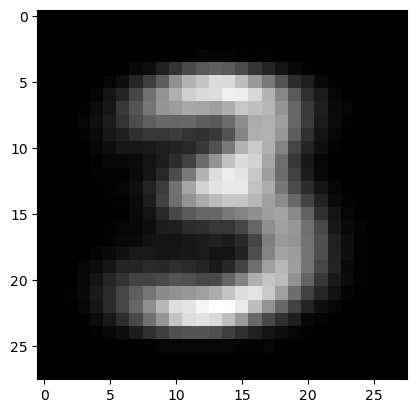

In [5]:
test = finMeans.reshape(3,28,28)
plt.imshow(test[0,:],cmap=plt.get_cmap('gray'))

In [6]:
sData, sTarget = shuffle(mnist3, mnist.target.to_numpy(), random_state=30)
returnData = np.array([sData[i] for i in range(len(sData)) if sTarget[i] in ['2','3','9']])

In [7]:
finMeans[1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     